Group 2 Members: Marcos Conde, Jose Manuel Lopez Camuñas, Alex Martin Martinez

In [1]:
!pip install tqdm

In [2]:
import cv2
import numpy as np
import pickle
import os
import warnings
import pandas as pd
from joblib import Parallel, delayed
import multiprocessing
from tqdm import tqdm
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, KFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import PowerTransformer

num_cores = multiprocessing.cpu_count()

warnings.filterwarnings('ignore')

Let us first read the train and test files

In [3]:
train_images_filenames = pickle.load(open('train_images_filenames.dat','rb'))
test_images_filenames = pickle.load(open('test_images_filenames.dat','rb'))
train_images_filenames = ['..' + n[15:] for n in train_images_filenames]
test_images_filenames  = ['..' + n[15:] for n in test_images_filenames]

train_labels = pickle.load(open('train_labels.dat','rb'))
test_labels = pickle.load(open('test_labels.dat','rb'))

UnpicklingError: the STRING opcode argument must be quoted

We create a SIFT object detector and descriptor. We compute the SIFT descriptors for all the train images and subsequently build a numpy array with all the descriptors stacked together.

# Bag of words with Dense SIFT

First it will be tested the optimal scale to be used with the dense SIFT. The number of keypoints used will be 5000 as in the previous week we found that the best results were achieved when this number of keypoints were used. 

In [3]:
def evaluate_lda(visual_words_train, visual_words_test,n_components=7,n_neighbors=5,metric='euclidean', cross_val = True):
    if not cross_val:
        lda = LinearDiscriminantAnalysis(n_components=n_components)
        VWlda = lda.fit_transform(visual_words_train,train_labels)
        knnlda = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
        knnlda.fit(VWlda, train_labels) 
        vwtestlda = lda.transform(visual_words_test)
        accuracy = 100*knnlda.score(vwtestlda, test_labels)
        return accuracy
    
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    accuracy = []
    
    def accuracy_cal(train_index, test_index):
        
        X_train, X_test = visual_words_train[train_index], visual_words_train[test_index]
        y_train, y_test = np.array(train_labels)[train_index.astype(int)], np.array(train_labels)[test_index.astype(int)]   
        X_test, y_test = np.concatenate((X_test,visual_words_test)), np.concatenate((y_test,test_labels))
        lda = LinearDiscriminantAnalysis(n_components=n_components)
        VWlda = lda.fit_transform(X_train ,y_train)
        knnlda = KNeighborsClassifier(n_neighbors=n_neighbors,n_jobs=-1,metric=metric)
        knnlda.fit(VWlda, y_train)
        vwtestlda = lda.transform(X_test)
        accuracy.append(100*knnlda.score(vwtestlda, y_test))
        
    
    Parallel(n_jobs=num_cores)(delayed(accuracy_cal)(train_index, test_index)for train_index, test_index in tqdm(kf.split(visual_words_train),desc='Evaluation: '))
        
        
    
    return sum(accuracy)/len(accuracy)

In [18]:
k = 128
codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)

def get_visual_words(descriptors,descriptors_np,codebook,k,test=False):
    
    if not test:
        codebook.fit(descriptors_np)
        
    visual_words = np.zeros((len(descriptors), k), dtype=np.float32)
    def get_words_and_visual(i):
        
        words = codebook.predict(descriptors[i])
        visual_words[i,:] = np.bincount(words, minlength=k)
        return words
    
    words = Parallel(n_jobs=num_cores,backend='threading')(delayed(get_words_and_visual)(i) for i in tqdm(range(len(descriptors)),total=len(descriptors)))
        
    
    return words, visual_words

In [5]:
def get_dense_SIFT_features(images, lbls, nfeatures=5000,scaling=1):
    descriptors = []
    label_per_descriptor = []
    descriptors_np = None
    sift = cv2.xfeatures2d.SIFT_create(nfeatures=nfeatures)
    
    def descriptors_and_labels(filename, label):
        ima = cv2.imread(filename)
        gray = cv2.cvtColor(ima, cv2.COLOR_BGR2GRAY)
        gray = cv2.resize(gray, (gray.shape[0]//scaling,gray.shape[1]//scaling), interpolation = cv2.INTER_AREA)
        step_size = 5
        kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size) 
                                        for x in range(0, gray.shape[1], step_size)]
        
        kp, des = sift.compute(gray, kp)
        descriptors.append(des)
        label_per_descriptor.append(label)
        
    
    Parallel(n_jobs=num_cores,backend='threading')(delayed(descriptors_and_labels)(filename,label)for filename, label in tqdm(zip(images,lbls),total = len(images)))
        
    
    descriptors_np = np.vstack(descriptors)

    
    return descriptors_np, descriptors, label_per_descriptor

In [6]:
def evaluate_dense_SIFT(nfeatures=5000,scaling=1, k=128):
    print("Evaluating Dense SIFT with {} features and scaling {}".format(nfeatures,scaling))
    print(50*"-")
    train_descriptors_np, train_descriptors, train_label_per_descriptor = get_dense_SIFT_features(train_images_filenames, train_labels, nfeatures,scaling)
    test_descriptors_np, test_descriptors, test_label_per_descriptor = get_dense_SIFT_features(test_images_filenames, test_labels, nfeatures,scaling)

    words_train, visual_words_train = get_visual_words(train_descriptors,train_descriptors_np,codebook,k)
    words_test, visual_words_test = get_visual_words(test_descriptors,test_descriptors_np,codebook,k,test=True)

    lda_acc = evaluate_lda(visual_words_train, visual_words_test, n_components=7,n_neighbors=5,metric='euclidean')
    return [lda_acc]

In [15]:
scales = [1,2,4,8]

results = {}

for n in scales: 
    results[str(n)+" scaling"] = evaluate_dense_SIFT(nfeatures=5000,scaling=n)



  0%|                                                                                         | 0/1881 [00:00<?, ?it/s]

Evaluating Dense SIFT with 5000 features and scaling 1
--------------------------------------------------




  0%|▎                                                                                | 8/1881 [00:00<00:49, 38.02it/s]

  1%|▌                                                                               | 12/1881 [00:00<01:11, 26.15it/s]

  1%|▋                                                                               | 16/1881 [00:00<01:36, 19.30it/s]

  1%|▊                                                                               | 20/1881 [00:01<01:45, 17.61it/s]

  1%|█                                                                               | 24/1881 [00:01<01:47, 17.24it/s]

  1%|█▏                                                                              | 28/1881 [00:01<01:58, 15.70it/s]

  2%|█▎                                                                              | 32/1881 [00:01<01:58, 15.58it/s]

  2%|█▌                                                                              | 36/1881 [00:02<01:48, 17.06it/s]

  2%|█▋                       

 27%|█████████████████████▋                                                         | 516/1881 [00:32<01:32, 14.70it/s]

 28%|█████████████████████▊                                                         | 520/1881 [00:32<01:29, 15.23it/s]

 28%|██████████████████████                                                         | 524/1881 [00:32<01:30, 15.05it/s]

 28%|██████████████████████▏                                                        | 528/1881 [00:32<01:35, 14.19it/s]

 28%|██████████████████████▎                                                        | 532/1881 [00:33<01:29, 15.14it/s]

 28%|██████████████████████▌                                                        | 536/1881 [00:33<01:19, 17.02it/s]

 29%|██████████████████████▋                                                        | 540/1881 [00:33<01:28, 15.20it/s]

 29%|██████████████████████▊                                                        | 544/1881 [00:33<01:28, 15.02it/s]

 29%|███████████████████████    

 55%|██████████████████████████████████████████▋                                   | 1028/1881 [01:04<00:50, 16.84it/s]

 55%|██████████████████████████████████████████▊                                   | 1032/1881 [01:04<00:51, 16.37it/s]

 55%|██████████████████████████████████████████▉                                   | 1036/1881 [01:05<00:49, 17.17it/s]

 55%|███████████████████████████████████████████▏                                  | 1040/1881 [01:05<00:51, 16.44it/s]

 56%|███████████████████████████████████████████▎                                  | 1044/1881 [01:05<00:49, 17.01it/s]

 56%|███████████████████████████████████████████▍                                  | 1048/1881 [01:05<00:46, 17.84it/s]

 56%|███████████████████████████████████████████▌                                  | 1052/1881 [01:06<00:49, 16.70it/s]

 56%|███████████████████████████████████████████▊                                  | 1056/1881 [01:06<00:48, 16.94it/s]

 56%|███████████████████████████

 82%|███████████████████████████████████████████████████████████████▊              | 1540/1881 [01:38<00:22, 14.98it/s]

 82%|████████████████████████████████████████████████████████████████              | 1544/1881 [01:38<00:20, 16.39it/s]

 82%|████████████████████████████████████████████████████████████████▏             | 1548/1881 [01:38<00:22, 15.07it/s]

 83%|████████████████████████████████████████████████████████████████▎             | 1552/1881 [01:39<00:19, 17.01it/s]

 83%|████████████████████████████████████████████████████████████████▌             | 1556/1881 [01:39<00:18, 17.27it/s]

 83%|████████████████████████████████████████████████████████████████▋             | 1560/1881 [01:39<00:19, 16.49it/s]

 83%|████████████████████████████████████████████████████████████████▊             | 1564/1881 [01:39<00:19, 16.43it/s]

 83%|█████████████████████████████████████████████████████████████████             | 1568/1881 [01:39<00:19, 16.14it/s]

 84%|███████████████████████████

 20%|████████████████▎                                                               | 164/807 [00:15<00:47, 13.56it/s]

 21%|████████████████▋                                                               | 168/807 [00:15<00:42, 15.14it/s]

 21%|█████████████████                                                               | 172/807 [00:15<00:40, 15.62it/s]

 22%|█████████████████▍                                                              | 176/807 [00:15<00:39, 16.03it/s]

 22%|█████████████████▊                                                              | 180/807 [00:16<00:43, 14.42it/s]

 23%|██████████████████▏                                                             | 184/807 [00:16<00:40, 15.44it/s]

 23%|██████████████████▋                                                             | 188/807 [00:16<00:40, 15.12it/s]

 24%|███████████████████                                                             | 192/807 [00:16<00:39, 15.64it/s]

 24%|███████████████████▍       

 84%|███████████████████████████████████████████████████████████████████             | 676/807 [00:53<00:09, 13.87it/s]

 84%|███████████████████████████████████████████████████████████████████▍            | 680/807 [00:53<00:08, 14.22it/s]

 85%|███████████████████████████████████████████████████████████████████▊            | 684/807 [00:53<00:08, 15.06it/s]

 85%|████████████████████████████████████████████████████████████████████▏           | 688/807 [00:53<00:08, 13.93it/s]

 86%|████████████████████████████████████████████████████████████████████▌           | 692/807 [00:54<00:08, 14.35it/s]

 86%|████████████████████████████████████████████████████████████████████▉           | 696/807 [00:54<00:07, 14.22it/s]

 87%|█████████████████████████████████████████████████████████████████████▍          | 700/807 [00:54<00:07, 14.51it/s]

 87%|█████████████████████████████████████████████████████████████████████▊          | 704/807 [00:54<00:06, 15.09it/s]

 88%|███████████████████████████

 39%|██████████████████████████████▌                                                | 728/1881 [01:31<00:19, 58.99it/s]

 39%|██████████████████████████████▉                                                | 736/1881 [01:31<00:18, 60.32it/s]

 40%|███████████████████████████████▏                                               | 744/1881 [01:32<00:18, 60.59it/s]

 40%|███████████████████████████████▊                                               | 756/1881 [01:32<00:16, 67.71it/s]

 41%|████████████████████████████████                                               | 764/1881 [01:32<00:16, 65.95it/s]

 41%|████████████████████████████████▍                                              | 771/1881 [01:32<00:16, 66.03it/s]

 41%|████████████████████████████████▋                                              | 778/1881 [01:32<00:21, 50.64it/s]

 42%|████████████████████████████████▉                                              | 784/1881 [01:32<00:21, 50.74it/s]

 42%|███████████████████████████

 87%|████████████████████████████████████████████████████████████████████          | 1640/1881 [01:52<00:03, 73.00it/s]

 88%|████████████████████████████████████████████████████████████████████▎         | 1648/1881 [01:52<00:03, 65.31it/s]

 88%|████████████████████████████████████████████████████████████████████▋         | 1656/1881 [01:52<00:03, 68.81it/s]

 88%|█████████████████████████████████████████████████████████████████████         | 1664/1881 [01:53<00:03, 71.68it/s]

 89%|█████████████████████████████████████████████████████████████████████▍        | 1676/1881 [01:53<00:02, 74.74it/s]

 90%|█████████████████████████████████████████████████████████████████████▉        | 1688/1881 [01:53<00:02, 78.08it/s]

 90%|██████████████████████████████████████████████████████████████████████▍       | 1700/1881 [01:53<00:02, 81.76it/s]

 91%|██████████████████████████████████████████████████████████████████████▊       | 1709/1881 [01:53<00:02, 82.29it/s]

 91%|███████████████████████████

Evaluating Dense SIFT with 5000 features and scaling 2
--------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 807/807 [00:01<00:00, 603.85it/s]
Evaluation: : 5it [00:00, 358.07it/s]
  2%|█▎                                                                             | 32/1881 [00:00<00:05, 311.51it/s]

Evaluating Dense SIFT with 5000 features and scaling 4
--------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 807/807 [00:01<00:00, 543.42it/s]
Evaluation: : 5it [00:00, 417.83it/s]
  3%|██▌                                                                            | 60/1881 [00:00<00:03, 589.81it/s]

Evaluating Dense SIFT with 5000 features and scaling 8
--------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 807/807 [00:00<00:00, 811.59it/s]
Evaluation: : 5it [00:00, 626.61it/s]


In [17]:
df = pd.DataFrame.from_dict(results, orient='index')
df.columns = ["KNN-LDA"]
df

,KNN-LDA
1 scaling,79.023140
2 scaling,73.208331
4 scaling,60.057430
8 scaling,46.433412


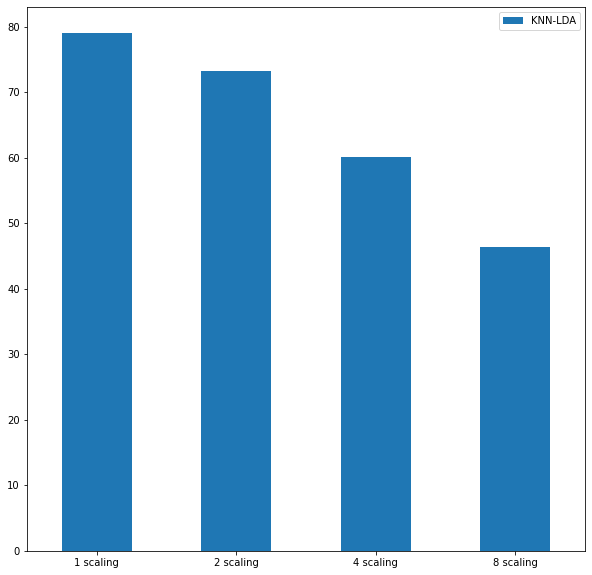

In [18]:
df.plot(kind="bar",figsize=(10,10), rot=0)

We will also look if varying the number of features in the downsacaled images can produce better results. We will test it with images being reduced 4 times it's original size

In [19]:
opt = [100,1000,5000, 10000,50000]

results = {}

for n in opt:   
    results[str(n)+" features"] = evaluate_dense_SIFT(nfeatures=n,scaling=4)


  1%|▊                                                                              | 20/1881 [00:00<00:13, 136.42it/s]

Evaluating Dense SIFT with 100 features and scaling 4
--------------------------------------------------



 84%|█████████████████████████████████████████████████████████████████▉            | 1589/1881 [00:16<00:03, 83.60it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 1881/1881 [00:21<00:00, 88.89it/s]

 88%|██████████████████████████████████████████████████████████████████████▌         | 712/807 [00:13<00:01, 56.27it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 807/807 [00:14<00:00, 54.14it/s]

100%|█████████████████████████████████████████████████████████████████████████████| 1881/1881 [00:03<00:00, 618.57it/s]

100%|███████████████████████████████████████████████████████████████████████████████| 807/807 [00:01<00:00, 629.21it/s]

Evaluation: : 5it [00:00, 250.68it/s]

  1%|▋                                                                              | 16/1881 [00:00<00:12, 151.35it/s]

Evaluating Dense SIFT with 1000 features and scaling 4
--------------------------------------------------



 79%|█████████████████████████████████████████████████████████████▌                | 1484/1881 [00:16<00:05, 74.14it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 1881/1881 [00:21<00:00, 85.60it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 807/807 [00:11<00:00, 71.55it/s]

 25%|███████████████████▋                                                          | 476/1881 [00:01<00:03, 432.48it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 1881/1881 [00:04<00:00, 430.31it/s]

100%|███████████████████████████████████████████████████████████████████████████████| 807/807 [00:01<00:00, 457.53it/s]

Evaluation: : 5it [00:00, 263.87it/s]

  1%|▋                                                                              | 16/1881 [00:00<00:13, 139.51it/s]

Evaluating Dense SIFT with 5000 features and scaling 4
--------------------------------------------------



 69%|█████████████████████████████████████████████████████▌                        | 1292/1881 [00:17<00:08, 67.52it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 1881/1881 [00:26<00:00, 71.28it/s]

 66%|████████████████████████████████████████████████████▋                           | 532/807 [00:08<00:04, 55.55it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 807/807 [00:15<00:00, 51.68it/s]

100%|█████████████████████████████████████████████████████████████████████████████| 1881/1881 [00:05<00:00, 351.26it/s]

100%|███████████████████████████████████████████████████████████████████████████████| 807/807 [00:01<00:00, 567.43it/s]

Evaluation: : 5it [00:00, 358.10it/s]

  1%|▋                                                                              | 16/1881 [00:00<00:14, 130.43it/s]

Evaluating Dense SIFT with 10000 features and scaling 4
--------------------------------------------------



 75%|██████████████████████████████████████████████████████████▋                   | 1416/1881 [00:17<00:06, 70.76it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 1881/1881 [00:24<00:00, 78.33it/s]

 80%|████████████████████████████████████████████████████████████████▏               | 648/807 [00:10<00:02, 63.45it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 807/807 [00:12<00:00, 62.85it/s]

100%|█████████████████████████████████████████████████████████████████████████████| 1881/1881 [00:02<00:00, 682.97it/s]

100%|███████████████████████████████████████████████████████████████████████████████| 807/807 [00:01<00:00, 673.18it/s]

Evaluation: : 5it [00:00, 418.12it/s]

  1%|▊                                                                              | 20/1881 [00:00<00:12, 149.66it/s]

Evaluating Dense SIFT with 50000 features and scaling 4
--------------------------------------------------



 75%|██████████████████████████████████████████████████████████▉                   | 1420/1881 [00:17<00:07, 64.48it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 1881/1881 [00:24<00:00, 77.37it/s]

 79%|███████████████████████████████████████████████████████████████                 | 636/807 [00:10<00:03, 50.44it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 807/807 [00:13<00:00, 60.81it/s]

100%|█████████████████████████████████████████████████████████████████████████████| 1881/1881 [00:03<00:00, 539.33it/s]

100%|███████████████████████████████████████████████████████████████████████████████| 807/807 [00:01<00:00, 522.71it/s]

Evaluation: : 5it [00:00, 313.37it/s]


In [20]:
df = pd.DataFrame.from_dict(results, orient='index')
df.columns = ["KNN-LDA"]
df

,KNN-LDA
100 features,59.770068
1000 features,61.020724
5000 features,60.057972
10000 features,60.260375
50000 features,59.398175


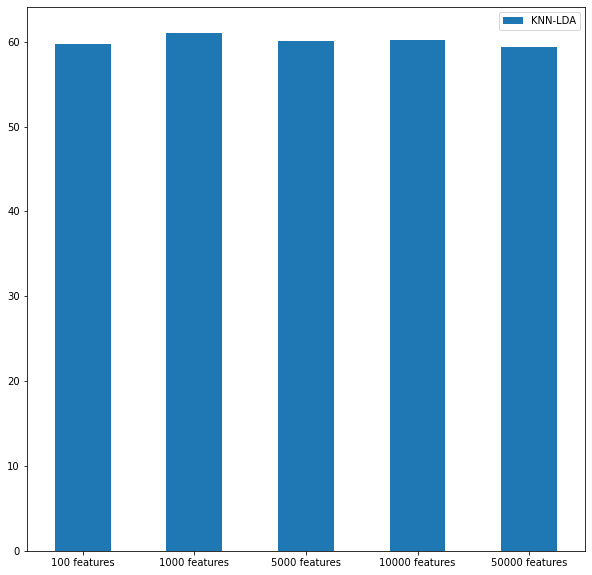

In [21]:
df.plot(kind="bar",figsize=(10,10), rot=0)

In [ ]:
#comentar 

# Testing different codebook k sizes for the dense SIFT

Using the previous scaling found to be the best one we will also test the best k for the previous seleceted parameters

In [23]:
def evaluate_k_codebook(k_values:list(),nfeatures=5000):
    

    train_descriptors_np, train_descriptors, train_label_per_descriptor = get_dense_SIFT_features(train_images_filenames, train_labels)
    test_descriptors_np, test_descriptors, test_label_per_descriptor = get_dense_SIFT_features(test_images_filenames, test_labels)
    
    results = {}
    
    for k in k_values:
        print("Evaluating SIFT with {} features and k={}".format(nfeatures,k))
        print(50*"-")
        codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
        words_train, visual_words_train = get_visual_words(train_descriptors,train_descriptors_np,codebook,k)
        words_test, visual_words_test = get_visual_words(test_descriptors,test_descriptors_np,codebook,k,test=True)

        results["k = "+str(k)]= evaluate_lda(visual_words_train, visual_words_test, n_components=7,n_neighbors=5,metric='euclidean')
        
    return results
    


opt = [32, 64, 128, 256, 512, 1024]

results = evaluate_k_codebook(nfeatures=2500, k_values=opt)

100%|████████████████████████████████████████████████████████████████████████████████| 807/807 [00:49<00:00, 16.16it/s]


Evaluating SIFT with 2500 features and k=32
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 807/807 [00:09<00:00, 84.39it/s]
Evaluation: : 5it [00:00, 179.05it/s]


Evaluating SIFT with 2500 features and k=64
--------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 807/807 [00:07<00:00, 107.37it/s]
Evaluation: : 5it [00:00, 128.55it/s]


Evaluating SIFT with 2500 features and k=128
--------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 807/807 [00:07<00:00, 113.14it/s]
Evaluation: : 5it [00:00, 143.24it/s]


Evaluating SIFT with 2500 features and k=256
--------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 807/807 [00:07<00:00, 114.34it/s]
Evaluation: : 5it [00:00, 161.72it/s]


Evaluating SIFT with 2500 features and k=512
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 807/807 [00:08<00:00, 94.21it/s]
Evaluation: : 5it [00:00, 217.95it/s]


Evaluating SIFT with 2500 features and k=1024
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 807/807 [00:13<00:00, 59.37it/s]
Evaluation: : 5it [00:00, 167.11it/s]


In [24]:
df = pd.DataFrame.from_dict(results, orient='index')
df.columns = ["KNN-LDA"]
df

,KNN-LDA
k = 32,69.235981
k = 64,76.132399
k = 128,80.831601
k = 256,81.761269
k = 512,79.901947
k = 1024,68.458497


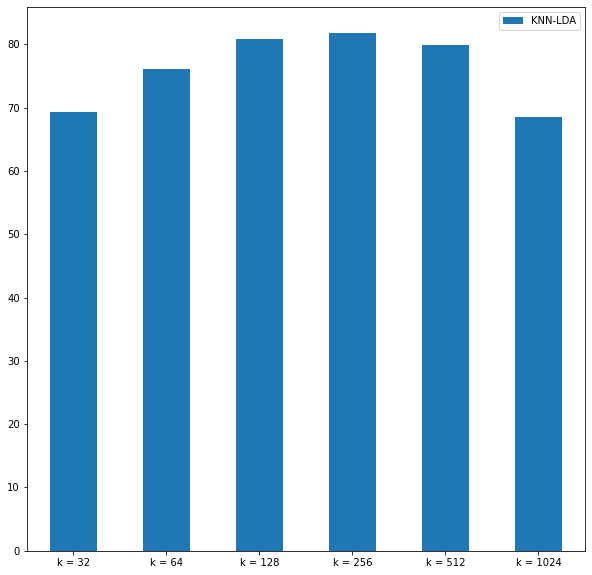

In [25]:
df.plot(kind="bar",figsize=(10,10), rot=0)

When varying the codebook sizes the number of bins used to produce the histograms changes. In this test we observe that for the three methods when 128 was used as the codebook size the results were better.

# Normalizing the data

Here it will be tested different data normalization methods to look if it can improve the performance of the previous methods

In [26]:
def evaluate_dense_SIFT_normalization(nfeatures=5000,scaling=1, k=256,norm='l1'):
    print("Evaluating Dense SIFT with {} features, scaling {} and {} normalization.".format(nfeatures,scaling,norm))
    print(50*"-")
    train_descriptors_np, train_descriptors, train_label_per_descriptor = get_dense_SIFT_features(train_images_filenames, train_labels, nfeatures,scaling)
    test_descriptors_np, test_descriptors, test_label_per_descriptor = get_dense_SIFT_features(test_images_filenames, test_labels, nfeatures,scaling)
    'Adding normalization of the descriptors'

    
        
    train_descriptors_np = Normalizer(norm=norm).fit_transform(train_descriptors_np)
    test_descriptors_np = Normalizer(norm=norm).fit_transform(test_descriptors_np)
    for i in range(len(train_descriptors)):
        train_descriptors[i] = Normalizer(norm=norm).fit_transform(train_descriptors[i])
    for i in range(len(test_descriptors)):
        test_descriptors[i] = Normalizer(norm=norm).fit_transform(test_descriptors[i])
    
    words_train, visual_words_train = get_visual_words(train_descriptors,train_descriptors_np,codebook,k)
    words_test, visual_words_test = get_visual_words(test_descriptors,test_descriptors_np,codebook,k,test=True)

    lda_acc = evaluate_lda(visual_words_train, visual_words_test, n_components=7,n_neighbors=5,metric='euclidean')
    return [lda_acc]

  0%|▎                                                                         | 7/1881 [1:06:41<297:33:49, 571.63s/it]


In [27]:
norms = ['l1','l2']

results={}

for norm in norms: 
    results["Normalization used:  "+str(norm)] = evaluate_dense_SIFT_normalization(norm = norm)

  0%|▎                                                                                | 8/1881 [00:00<00:30, 61.49it/s]

Evaluating Dense SIFT with 5000 features, scaling 1 and l1 normalization.
--------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 807/807 [00:05<00:00, 161.19it/s]
Evaluation: : 5it [00:00, 102.31it/s]
  0%|                                                                                         | 0/1881 [00:00<?, ?it/s]

Evaluating Dense SIFT with 5000 features, scaling 1 and l2 normalization.
--------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 807/807 [00:04<00:00, 166.12it/s]
Evaluation: : 5it [00:00, 125.33it/s]
  0%|                                                                                         | 0/1881 [00:00<?, ?it/s]

Evaluating Dense SIFT with 5000 features, scaling 1 and power normalization.
--------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 807/807 [00:50<00:00, 16.12it/s]


KeyboardInterrupt: 

In [24]:
df = pd.DataFrame.from_dict(results, orient='index')
df.columns = ["KNN-LDA"]
df

,KNN-LDA
Normalization used: l1,76.047968
Normalization used: l2,78.667997


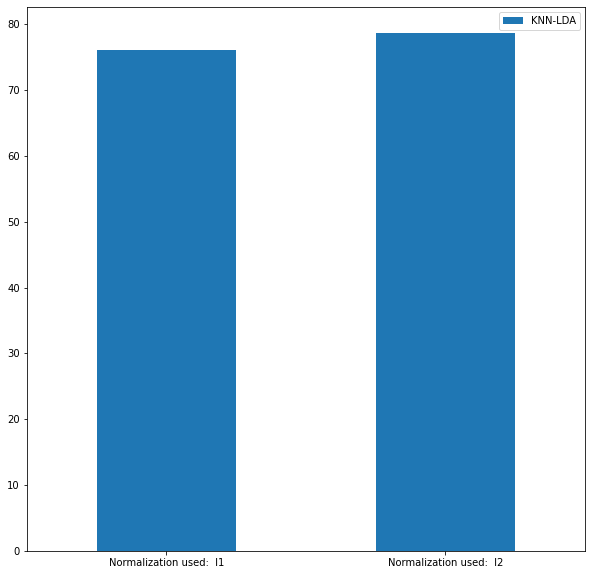

In [25]:
df.plot(kind="bar",figsize=(10,10), rot=0)

# Dense SIFT with SVM